**ОПИСАНИЕ ПРОЕКТА:**

В сервисе аренды самокатов GoFast имеются два вида пользователей: 

•	без подписки

    o	абонентская плата отсутствует;
    
    o	стоимость одной минуты поездки — 88 рублей;
    
    o	стоимость старта (начала поездки) — 50 рублей;
    
•	с подпиской Ultra 

    o	абонентская плата — 199 рублей в месяц;
    
    o	стоимость одной минуты поездки — 66 рублей;
    
    o	стоимость старта — бесплатно.
    
Нужно проанализировать поведение этих двух групп пользователей, а также принять решение о целесообразности увеличения доли пользователей с подпиской

ОПИСАНИЕ ДАННЫХ:

Имеются три таблицы с данными: 

• Пользователи — users_go.csv

• Поездки — rides_go.csv

• Подписки — subscriptions_go.csv


В ХОДЕ РАБОТЫ 

•	мы проведем проверку данных: удалим дубликаты, добавим пропущенные значения и создадим недостающие столбцы с данными 

•	создадим общую таблицу с данными и таблицы с данными о пользователях с подпиской и без подписки 

•	изучим информацию о расстоянии и и времени поездок пользователей

•	посчитаем и проанализируем помесячную выручку 

•	проверим гипотизы о поведении пользователей с подпиской и без подписки

    o	тратят ли пользователи с подпиской больше времени на поездки?
    
    o	можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает           
    o   оптимальное расстояние с точки зрения износа самоката 3130 метров? 
    o   будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import binom
from math import sqrt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

#Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы

In [3]:
users.head() #Выводим первые строки пользователей   

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
#Выводим первые строки поездок  
    
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()  #Выводим первые строки подписок  

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
#смотрим информацию про датасет users

users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
#смотрим информацию про датасет rides

rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
#смотрим информацию про датасет subscriptions

subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В таблице: 

• <b>users</b> 1565 записи и данные типа "целые числа" и "вещественные числа". Изменение типа данных не требуется

• <b>rides</b> 18068 записи и данные типа "целые числа" и "вещественные числа". Изменение типа данных не требуется

• <b>subscriptions</b> 2 записи и данные типа "целые числа" и "строка". Изменение типа данных не требуется


#### Шаг 2. Предобработка данных

In [9]:
# Приведим столбец date к типу даты pandas 
rides['date'] = pd.to_datetime(rides['date'])

rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [10]:
#Создаем новый столбец с номером месяца на основе столбца date

rides['month'] = rides['date'].dt.month 

rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [11]:
#v_1: Создаем новый столбец с годом на основе столбца date

rides['year'] = rides['date'].dt.year

rides.head()

,user_id,distance,duration,date,month,year
0,1,4409.919140,25.599769,2021-01-01,1,2021
1,1,2617.592153,15.816871,2021-01-18,1,2021
2,1,754.159807,6.232113,2021-04-20,4,2021
3,1,2694.783254,18.511000,2021-08-11,8,2021
4,1,4028.687306,26.265803,2021-08-28,8,2021


In [12]:
rides['year'].unique()

array([2021])

Данные представлены за один год (2021)

In [13]:
# смотрим наличие пропущенных значений в users

users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

пропущенных значений не обнаружено

In [14]:
# смотрим наличие пропущенных значений в subscriptions

subscriptions.isna().sum()

# пропущенных значений не обнаружено

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [15]:
# смотрим наличие пропущенных значений в rides

rides.isna().sum()

# пропущенных значений не обнаружено

user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64

In [16]:
#проверяем нет ли явных дубликатов в users

users.duplicated().sum()

# обнаружен 31 явный дубликат

31

In [17]:
#избавляемся от явных дубликатов в users

users = users.drop_duplicates()
users = users.reset_index(drop=True)
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [18]:
#проверяем нет ли явных дубликатов в users

users.duplicated().sum()

#явных дубликатов нет

0

In [19]:
#проверяем нет ли явных дубликатов в subscriptions

subscriptions.duplicated().sum()

# явных дубликатов не обнаружено

0

In [20]:
#проверяем нет ли явных дубликатов в rides

rides.duplicated().sum()

#явных дубликатов не обнаружено

0

#### Шаг 3. Исследовательский анализ данных

In [21]:
#смотрим частоту встречаемости городов и создаем таблицу city_frequency
 
city_frequency = users['city'].value_counts()

#смотрим соотношение в процентах 
city_percentage = users['city'].value_counts()/len(users) * 100

#создаем общую таблицу

data_city = pd.concat([city_frequency,city_percentage], axis=1).round(2)
data_city.columns = ['quantity','percentage']
data_city

,quantity,percentage
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


In [22]:
data_city.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Пятигорск to Москва
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quantity    8 non-null      int64  
 1   percentage  8 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 192.0+ bytes


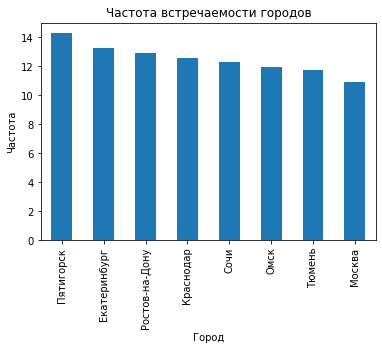

In [23]:
#v_1: строим столбчатую диаграмму

data_city.plot(y='percentage', kind='bar', legend=None)
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота')
plt.show()

# самый встречаемый город - Пятигорск. Наименее встречаемый - Москва. Этот город стоит после Тюмени, что на мой взгляд странно, т.к. аренда самокатов в Москве очень развита

In [24]:
# смотрим соотношение пользователей с подпиской и без подписки

user_ratio = users['subscription_type'].value_counts()

#смотрим соотношение в процентах 
user_percentage = users['subscription_type'].value_counts()/len(users) * 100

#создаем общую таблицу

data_subscription = pd.concat([user_ratio,user_percentage], axis=1).round(2)
data_subscription.columns = ['quantity','percentage']
data_subscription

,quantity,percentage
free,835,54.43
ultra,699,45.57


Text(0.5, 1.0, 'Соотношение пользователей с подпиской и без подписки')

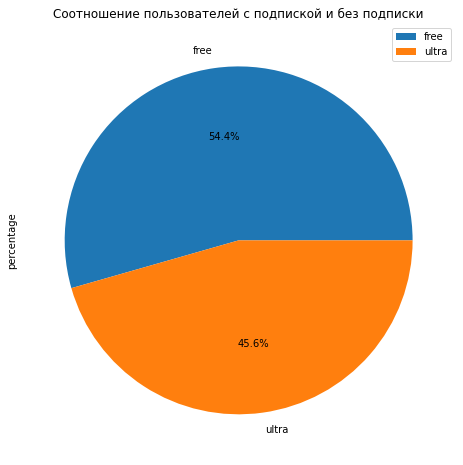

In [25]:
#строим круговую диаграмму

data_subscription.plot(y='percentage', kind='pie', figsize=(8, 8), autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')

#пользователей без подписок чуть больше, чем пользователей с подпиской

In [26]:
# смотрим соотношение возраста пользователей

age_ratio = users['age'].value_counts()

#смотрим соотношение в процентах 
age_percentage = users['age'].value_counts()/len(users) * 100

#создаем общую таблицу

data_age = pd.concat([age_ratio, age_percentage], axis=1).round(2)
data_age.columns = ['quantity','percentage']
data_age

,quantity,percentage
25,145,9.45
24,132,8.60
26,131,8.54
23,129,8.41
27,119,7.76
22,119,7.76
28,112,7.30
21,93,6.06
20,71,4.63
30,68,4.43


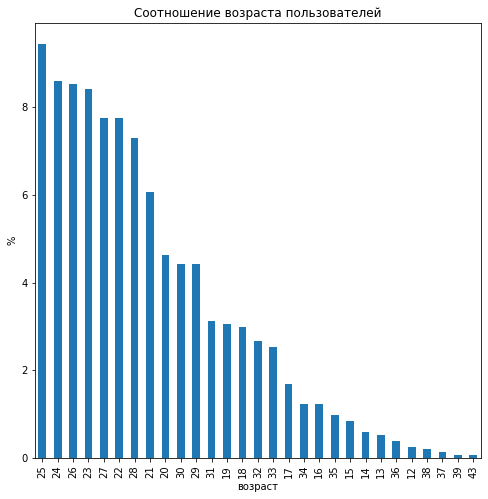

In [27]:
# строим столбчатую диаграмму

data_age.plot(y='percentage', kind='bar',figsize=(8, 8), legend=None)
plt.title('Cоотношение возраста пользователей')
plt.xlabel('возраст')
plt.ylabel('%')
plt.show()

# наибольший процент людей в возрасте 26,25 и 24 года. Меньше всего пользуются люди 37-39 и 43 года

In [28]:
# v_1: 
        
data_age.describe().round(2)

,quantity,percentage
count,29.00,29.00
mean,52.90,3.45
std,48.82,3.18
min,1.00,0.07
25%,9.00,0.59
50%,41.00,2.67
75%,93.00,6.06
max,145.00,9.45


count   количество наблюдений в наборе данных - 29
mean    среднее арифметическое 3,45% или 52,90
std     стандартное отклонение 3.18% или 48,82
min     минимальное значение 1 или 0,07%
25%     первый квартиль 9 или 0,59%
50%     медиана, или второй квартиль 41 или 2,67%
75%     третий квартиль  93 или 6,06 %
max     максимальное значение 145 или 9,45 %
dtype: float64 # тип данных 

In [29]:
# Задаем интервалы группировки по 5 годам
bins = list(range(10, max(users['age']) + 6, 5))

# Группируем данные по 5 годам
age_groups = pd.cut(users['age'], bins=bins, right=False)

# Получаем количество значений в каждой группе
age_ratio_grouped = age_groups.value_counts()
age_ratio_grouped

[25, 30)    575
[20, 25)    544
[30, 35)    215
[15, 20)    151
[35, 40)     27
[10, 15)     21
[40, 45)      1
Name: age, dtype: int64

Text(0, 0.5, 'Частота')

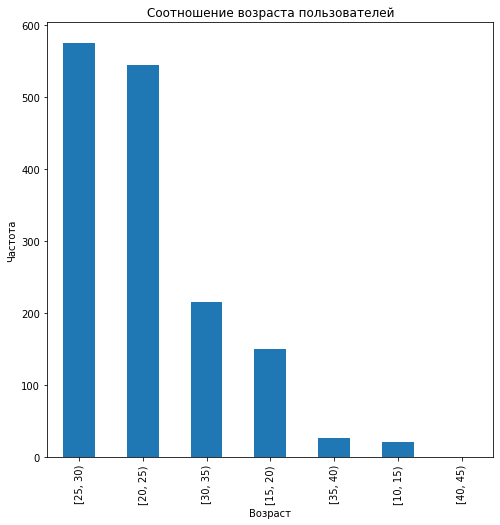

In [30]:
#строим столбчатую диаграмму

age_ratio_grouped.plot(y='age', kind='bar', figsize=(8, 8))
plt.title('Cоотношение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')

# на первом месте услугой проката самокатов пользуются люди в возрасте 25-30 лет и 2025 лет. Люди старше 40 не пользуются совсем. Также на предпоследнем месте 10-15 лет

In [31]:
#отсортируем значения столбца 'расстояние' по возрастанию

rides['distance'].sort_values()

11555       0.855683
9541        2.570787
13690       4.329506
8658        6.784447
7841        7.097072
            ...     
17242    6724.932981
17171    6760.940067
15580    6908.491343
16484    7066.003772
16309    7211.007745
Name: distance, Length: 18068, dtype: float64

Text(0, 0.5, 'Количество поездок')

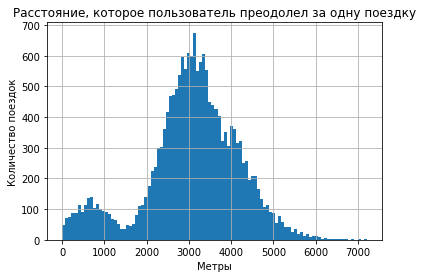

In [32]:
#построим гистограмму

rides['distance'].hist(bins=100)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Метры')
plt.ylabel('Количество поездок')

# гистограмма имеет распределение, близкое к нормальному с двумя пиками на отметках 3100 м и 800 м

In [33]:
#отсортируем значения столбца 'продолжительность' по возрастанию

rides['duration'].sort_values()

12013     0.500000
17314     0.500000
15029     0.500000
7437      0.500000
12967     0.500000
           ...    
6453     38.265229
1998     38.352763
2623     39.526602
4709     39.873856
4215     40.823963
Name: duration, Length: 18068, dtype: float64

Text(0, 0.5, 'Количество поездок')

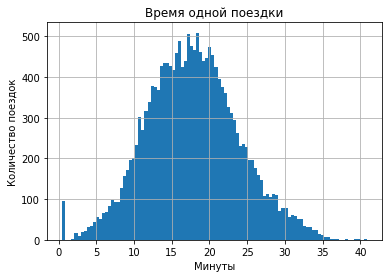

In [34]:
#строим гистограмму

rides['duration'].hist(bins=100)
plt.title('Время одной поездки')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')

# гистограмма имеет распределение, близкое к нормальному с наибольшей частотой в промежутке 15-20 минут. Пик в 30 секунд является скорее всего погрешностью системы. Когда пытаются взять в аренду, а потом перезагружают   

Text(0, 0.5, 'Количество поездок')

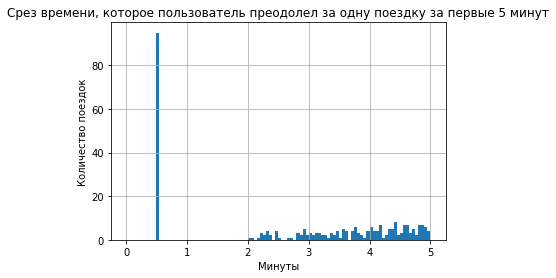

In [35]:
# v_1: рассматриваем значения длительности до 5-ти минут подробнее 

rides['duration'].hist(bins=100, range = (0, 5))

plt.title('Срез времени, которое пользователь преодолел за одну поездку за первые 5 минут')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')

видим много значений на отметке 30 секунд, попытаемся выяснить, что это за значения и приносят ли они выручку

In [36]:
rides_min = rides.query('duration < 1')
rides_min.head()

,user_id,distance,duration,date,month,year
6531,701,4196.445201,0.5,2021-08-31,8,2021
6570,704,4830.824371,0.5,2021-10-14,10,2021
6680,712,4684.004397,0.5,2021-03-04,3,2021
6695,713,5215.642710,0.5,2021-02-25,2,2021
6768,718,5197.436649,0.5,2021-02-11,2,2021


In [37]:
 rides_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 6531 to 17909
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   95 non-null     int64         
 1   distance  95 non-null     float64       
 2   duration  95 non-null     float64       
 3   date      95 non-null     datetime64[ns]
 4   month     95 non-null     int64         
 5   year      95 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 5.2 KB


Есть 95 пользователей, у которых короткие поездки (30 секунд) и длительная дистанция (около 5-ти км). За такое короткое время проехать такую дистанцию невозможно, может быть была какая-то акция или сбой? 

выручка изменится, но не сильно, т.к. она считается от времени продолжительности поездки, а не от расстояния. Т.е. каждая поездка в 30 секунд приносит выручку в размере 3-х рублей 

#### Шаг 4. Объединение данных

In [38]:
# Объединяем данные о пользователях, поездках и подписках в один датафрейм

users_rides =  users.merge(rides, on='user_id', how='left')

df_total = users_rides.merge(subscriptions, on='subscription_type', how='left')

df_total['duration'] = np.ceil(df_total['duration']) 

df_total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,2021,6,0,199


In [39]:
# v_1:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   year               18068 non-null  int64         
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(3)
memory 

In [40]:
df_total.duplicated().sum()

0

Объединение проведено корректно, нет дубликатов, количество строк совпадает с количеством строк в таблице riders

In [41]:
# Создаем датафрейм с данными о пользователях без подписок

df_free =  df_total.query('subscription_type == "free"')

# Вывод первых строк нового датафрейма
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,2021,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,2021,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,2021,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,2021,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,2021,8,50,0


In [42]:
# Создаем датафрейм с данными о пользователях с подписками

df_ultra =  df_total.query('subscription_type == "ultra"')

# Вывод первых строк нового датафрейма
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,2021,6,0,199


Text(0, 0.5, 'Количество поездок')

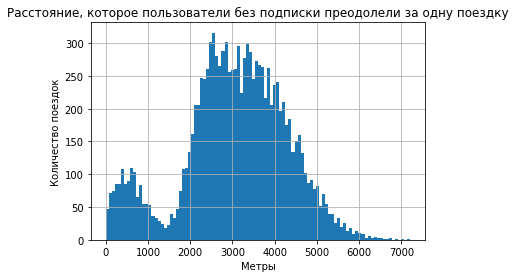

In [43]:
#строим гистограммы для расстояния поездок для пользователей без подписок

df_free['distance'].hist(bins=100)

plt.title('Расстояние, которое пользователи без подписки преодолели за одну поездку')
plt.xlabel('Метры')
plt.ylabel('Количество поездок')

Text(0, 0.5, 'Количество поездок')

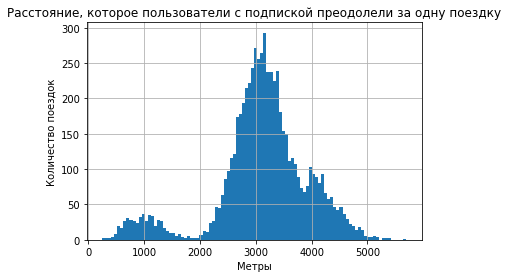

In [44]:
#строим гистограммы для расстояния поездок для пользователей с подпиской

df_ultra['distance'].hist(bins=100)
plt.title('Расстояние, которое пользователи с подпиской преодолели за одну поездку')
plt.xlabel('Метры')
plt.ylabel('Количество поездок')


Text(0, 0.5, 'Количество поездок')

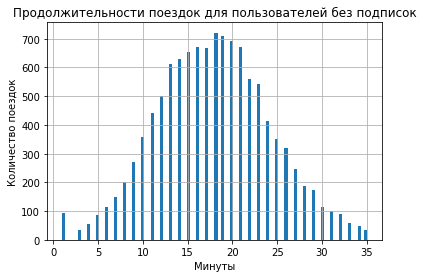

In [45]:
#строим гистограммы для продолжительности поездок для пользователей без подписок

df_free['duration'].hist(bins=100)

plt.title('Продолжительности поездок для пользователей без подписок')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')

Text(0, 0.5, 'Количество поездок')

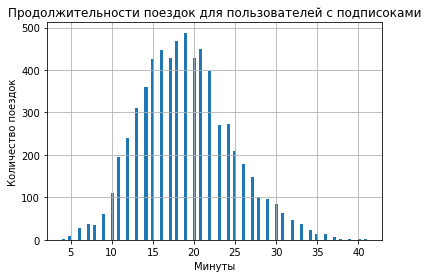

In [46]:
#строим гистограммы для продолжительности поездок для пользователей с подпиской

df_ultra['duration'].hist(bins=100)
plt.title('Продолжительности поездок для пользователей с подписоками')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')

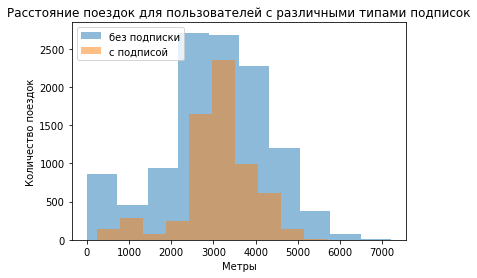

In [47]:
# Данные из датафрейма df_free
x = df_free['distance']

# Данные из датафрейма df_ultra
y = df_ultra['distance']

bins = np.linspace(0, 8000)

plt.hist(x, alpha=0.5, label='без подписки')
plt.hist(y, alpha=0.5, label='с подписой')

plt.legend(loc='upper left')

plt.title('Расстояние поездок для пользователей с различными типами подписок')
plt.xlabel('Метры')
plt.ylabel('Количество поездок')

plt.show()

распределение расстояний поездок для пользователей с подпиской или без подписок схоже - есть два пика на отметке около 1 000 м и большой пик в диапазоне 2 500 - 3 000 м. У пользователей с попиской также наблюдается небольшой пик на отметке 4 000 м. А вот на отметке 5 000 км заметно резкое падение расстояния перемещения у пользователей без подписки и практически отсутствие поездок на расстояние больше 5 км у пользователей с подпиской

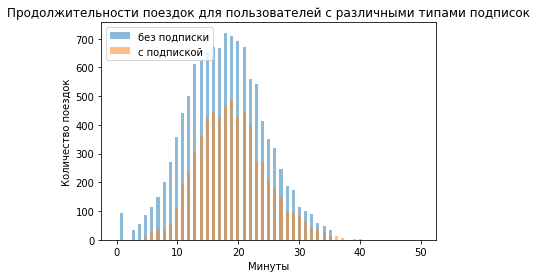

In [48]:
# Данные из датафрейма df_free
x = df_free['duration']

# Данные из датафрейма df_ultra
y = df_ultra['duration']

bins = np.linspace(0, 50, 100)

plt.hist(x, bins, alpha=0.5, label='без подписки')
plt.hist(y, bins, alpha=0.5, label='с подпиской')

plt.legend(loc='upper left')
plt.title('Продолжительности поездок для пользователей с различными типами подписок')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')

plt.show()

замечены аномалии во времени в 30 секунд. В обоих графиках мики около 18-23 минут и практически не берут в аренду самокаты на более, чем 35 минут

#### Шаг 5. Подсчёт выручки

In [49]:
df_total['month'] = df_total['date'].dt.month
trips_aggregated = df_total.groupby(['user_id', 'month']).agg({'distance': 'sum', 'duration': 'sum'})
trips_aggregated.rename(columns={'distance': 'total_distance', 'duration': 'total_duration'}, inplace=True)
trips_aggregated['total_trips'] = df_total.groupby(['user_id', 'month'])['user_id'].count()

trips_aggregated.reset_index(inplace=True)
trips_aggregated

,user_id,month,total_distance,total_duration,total_trips
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2
11327,1534,8,7622.453034,48.0,2
11328,1534,9,4928.173852,23.0,1
11329,1534,11,13350.015305,78.0,4


In [50]:
df_total

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,2021,8,50,0


In [51]:
# В trips_aggregated добавляем столбец с subscription_type
df_grouped = df_total.groupby('user_id')['subscription_type'].first().reset_index()
trips_aggregated = trips_aggregated.join(df_grouped.set_index('user_id'), on='user_id')

trips_aggregated

,user_id,month,total_distance,total_duration,total_trips,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,78.0,4,free


In [52]:
# В trips_aggregated добавляем столбец start_ride_price

def set_start_ride_price(row):
    if row['subscription_type'] == 'free':
        return 50
    else:
        return 0

# Применить функцию к DataFrame и установить значения в 'start_ride_price'
trips_aggregated['start_ride_price'] = trips_aggregated.apply(lambda row: set_start_ride_price(row), axis=1)

trips_aggregated

,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price
0,1,1,7027.511294,42.0,2,ultra,0
1,1,4,754.159807,7.0,1,ultra,0
2,1,8,6723.470560,46.0,2,ultra,0
3,1,10,5809.911100,32.0,2,ultra,0
4,1,11,7003.499363,56.0,3,ultra,0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,50
11327,1534,8,7622.453034,48.0,2,free,50
11328,1534,9,4928.173852,23.0,1,free,50
11329,1534,11,13350.015305,78.0,4,free,50


In [53]:
# В trips_aggregated добавляем столбец 'minute_price'

def set_start_ride_price(row):
    if row['subscription_type'] == 'free':
        return 8
    else:
        return 6

# Применить функцию к DataFrame и установить значения в 'start_ride_price'
trips_aggregated['minute_price'] = trips_aggregated.apply(lambda row: set_start_ride_price(row), axis=1)
trips_aggregated

,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price,minute_price
0,1,1,7027.511294,42.0,2,ultra,0,6
1,1,4,754.159807,7.0,1,ultra,0,6
2,1,8,6723.470560,46.0,2,ultra,0,6
3,1,10,5809.911100,32.0,2,ultra,0,6
4,1,11,7003.499363,56.0,3,ultra,0,6
...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,50,8
11327,1534,8,7622.453034,48.0,2,free,50,8
11328,1534,9,4928.173852,23.0,1,free,50,8
11329,1534,11,13350.015305,78.0,4,free,50,8


In [54]:
# В trips_aggregated добавляем столбец 'subscription_fee'

def set_subscription_fee(row):
    if row['subscription_type'] == 'free':
        return 0
    else:
        return 199

# Применить функцию к DataFrame и установить значения в 'start_ride_price'
trips_aggregated['subscription_fee'] = trips_aggregated.apply(lambda row: set_subscription_fee(row), axis=1)
trips_aggregated

,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price,minute_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,0,6,199
1,1,4,754.159807,7.0,1,ultra,0,6,199
2,1,8,6723.470560,46.0,2,ultra,0,6,199
3,1,10,5809.911100,32.0,2,ultra,0,6,199
4,1,11,7003.499363,56.0,3,ultra,0,6,199
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,50,8,0
11327,1534,8,7622.453034,48.0,2,free,50,8,0
11328,1534,9,4928.173852,23.0,1,free,50,8,0
11329,1534,11,13350.015305,78.0,4,free,50,8,0


In [55]:
# В trips_aggregated добавляем столбец с помесячной выручкой, которую принёс каждый пользователь

trips_aggregated['total_tr'] = trips_aggregated['start_ride_price']*trips_aggregated['total_trips'] + trips_aggregated['minute_price']*trips_aggregated['total_duration'] + trips_aggregated['subscription_fee']
trips_aggregated.reset_index()
trips_aggregated.head()

,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price,minute_price,subscription_fee,total_tr
0,1,1,7027.511294,42.0,2,ultra,0,6,199,451.0
1,1,4,754.159807,7.0,1,ultra,0,6,199,241.0
2,1,8,6723.470560,46.0,2,ultra,0,6,199,475.0
3,1,10,5809.911100,32.0,2,ultra,0,6,199,391.0
4,1,11,7003.499363,56.0,3,ultra,0,6,199,535.0


#### Шаг 6. Проверка гипотез

In [56]:
# Ho: средняя продолжительность сессии у подписчиков и не у подписчиков равны
# H1: средняя продолжительность сессии у подписчиков больше, чем не у подписчиков


alpha = 0.05 # уровень статистической значимости          

results = st.ttest_ind(df_ultra['duration'], df_free['duration'], equal_var=False, alternative='greater') 

print('p-значение:', results.pvalue)

if  results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки

In [57]:
#Н0: среднее расстояние поездки пользователей с подпиской равно 3130
#Н1: среднее расстояние пользователей с подпиской больше 3130.
# Односторонняя в сторону увеличения, или правосторонняя
# Тогда код будет следующим:

value = 3130 # нужное расстояние 
alpha = 0.05 
results = st.ttest_1samp(df_ultra['distance'], value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha: # введите ваш код тут:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


"Не получилось отвергнуть нулевую гипотезу" означает, что пользователи не проезжают расстояние больше 3130, т.е. проезжают расстояние, равное или меньше 3130 метров, что является оптимальным расстоянием с точки зрения износа самоката 

In [58]:
trips_aggregated_free = trips_aggregated.query('subscription_type == "free"')
trips_aggregated_free.rename(columns={'total_tr': 'total_tr_free'}, inplace=True)

trips_aggregated_free.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price,minute_price,subscription_fee,total_tr_free
4533,700,1,2515.690719,15.0,1,free,50,8,0,170.0
4534,700,2,13446.659764,89.0,5,free,50,8,0,962.0
4535,700,3,3798.334905,19.0,1,free,50,8,0,202.0
4536,700,4,2984.551206,16.0,1,free,50,8,0,178.0
4537,700,6,5927.650988,29.0,2,free,50,8,0,332.0


In [59]:
trips_aggregated_ultra = trips_aggregated.query('subscription_type == "ultra"')
trips_aggregated_ultra.rename(columns={'total_tr': 'total_tr_ultra'}, inplace=True)

trips_aggregated_ultra.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,user_id,month,total_distance,total_duration,total_trips,subscription_type,start_ride_price,minute_price,subscription_fee,total_tr_ultra
0,1,1,7027.511294,42.0,2,ultra,0,6,199,451.0
1,1,4,754.159807,7.0,1,ultra,0,6,199,241.0
2,1,8,6723.470560,46.0,2,ultra,0,6,199,475.0
3,1,10,5809.911100,32.0,2,ultra,0,6,199,391.0
4,1,11,7003.499363,56.0,3,ultra,0,6,199,535.0


In [60]:
# Ho: средняя ежемесячная выручка у подписчиков и у неподписчиков равны
# H1: средняя ежемесячная выручка у подписчиков, больше, чем не у подписчиков

alpha = 0.05 # уровень статистической значимости          

results = st.ttest_ind(trips_aggregated_ultra['total_tr_ultra'], trips_aggregated_free['total_tr_free'], equal_var=False, alternative='greater') 

print('p-значение:', results.pvalue)

if  results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Средняя ежемесячная выручка у подписчиков больше, чем не у подписчиков

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве средних для зависимых (парных) выборок

Нулевая гипотеза будет о том, что средние обращений равны

Альтернативная гипотеза будет о том, что средние обращений не равны

alpha = 0.05 # уровень статистической значимости

results = st.ttest_rel(before, after)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средних обращений')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве средних обращений')



#### Шаг 7. Распределения

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 1001 artists>

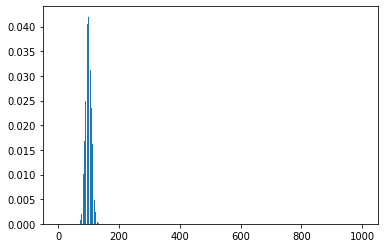

In [61]:
p = 0.1 # напишите ваш код здесь: какова вероятность продлить подписку?
n = 1000 # напишите ваш код здесь: сколько промокодов разошлем?

# напишите ваш код здесь: создайте список distr, в котором будете хранить значения распределения
distr = []

# напишите ваш код здесь: постройте распределение вероятностей
for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)   

In [62]:
# задаём параметры биномиального распределения
n = 1169
p = 0.1

mu = n * p
sigma = sqrt(n * p * (1 - p))


distr = st.norm(mu, sigma) # задайте нормальное распределение

result = distr.cdf(100) # найдите вероятность
print(result)

0.04971489312694162


Чтобы вероятность не выполнить план была примерно 5 %, нужно разослать минимум 1169 промокода. 

**ОБЩИЙ ВЫВОД** 

В ходе работы анализировались три таблицы с данными: 
• Пользователи — users_go.csv
• Поездки — rides_go.csv
• Подписки — subscriptions_go.csv:

1. Изначально проводилась проверка данных. Были выявлены и отфильтрованы дубликаты был найден (31 дубликат в users)
2. Изучили данные: 
    o	о частоте встречаемости городов. Самый встречаемый город - Пятигорск. Наименее встречаемый - Москва.
    o	о соотношении пользователей с подпиской и без подписки: Пользователей без подписки -  54.43%, пользователей с подпииской - 45.57 %
    o	о возрасте пользователей: наибольший процент людей в возрасте 26,25 и 24 года. Меньше всего пользуются люди 37-39 и 43 года
    o	о расстоянии, которое пользователь преодолел за одну поездку: чаще всего пользователи преодолевают расстояние 3100 м и берут также часто на короткие расстояния - около 800 м
    o	о продолжительности поездок: самое популярная продолжительность одной поездки - в промежутке 15-20 минут. Также есть время в 30 секунд, которое, скорее всего, является скорее всего погрешностью системы  

2. Затем данные из трех табличек свели в одну и разделили на две таблицы, сгрупированные по типу подписки: 

•	без подписки 
    o	абонентская плата отсутствует;
    o	стоимость одной минуты поездки — 88 рублей;
    o	стоимость старта (начала поездки) — 50 рублей;
•	с подпиской Ultra 
    o	абонентская плата — 199 рублей в месяц;
    o	стоимость одной минуты поездки — 66 рублей;
    o	стоимость старта — бесплатно.
    
3. Изучили данные о растоянии и времени поездок пользователей: распределение расстояний поездок для пользователей с подпиской или без подписок схоже - есть два пика на отметке около 1 000 м и большой пик в диапазоне 2 500 - 3 000 м. У пользователей с попиской также наблюдается небольшой пик на отметке 4 000 м. А вот на отметке 5 000 км заметно резкое падение расстояния перемещения у пользователей без подписки и практически отсутствие поездок на расстояние больше 5 км у пользователей с подпиской
4. Посчитали и проанализировали помесячную выручку пользователей и с подпиской и без подписки. Пользователи без подписки в среднем приносят меньшую выручку, чем пользователи с подпиской
5. Пользователи в среднем проезжают оптимальное расстояние с точки зрения износа самоката в 3130 метров